Bayes analyses

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import string
import re


def bplot(column, prefix=""):
    q1 = column.quantile(0.25)                 
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    mi = column.min()
    ma = column.max()
    return {
        prefix + 'median': column.median(),
        prefix + 'q1': q1,
        prefix + 'q3': q3,
        prefix + 'iqr': iqr,
        prefix + 'min_whisker': max(q1 - 1.5*iqr, mi),
        prefix + 'max_whisker': min(q3 + 1.5*iqr, ma),
        prefix + 'min': mi,
        prefix + 'max': ma,
    }
      
attributes = {
    "Branching-duration": "branching-<>duration",
    "Total-duration": "total-<>duration",
    "Commits B1": "commits <>B1",
    "Commits B2": "commits <>B2",
    "Committers B1": "committer <>B1",
    "Committers B2": "committer <>B2",
    "Changed Files B1": "changed-<>files B1",
    "Changed Files B2": "changed-<>files B2"
}

In [2]:
df = pd.read_excel("../Dataset-SBES2020.xlsx")

df.loc[df["Conflicts"] != "YES", 'Conflicts'] = "Without conflicts"
df.loc[df["Conflicts"] == "YES", 'Conflicts'] = "With conflicts"
YES = "With conflicts"

with_conflicts = df[df["Conflicts"] == YES]
without_conflicts = df[df["Conflicts"] != YES]


In [3]:
results = {}

for attr in attributes:
    ndf = df.sort_values(by=attr, ascending=False)
    x = []
    y = []
    with_conflicts_gt_t = 0
    branching_time_gt_t = 0
    total = len(ndf)
    # P(conflito | branching time > t) = P(conflito \intersecao branching time > t)/P(branching time > t)
    for i, row in ndf.iterrows():
        branching_time_gt_t += 1
        x.append(row[attr])
        if row["Conflicts"] == YES:
            with_conflicts_gt_t += 1
        y.append(with_conflicts_gt_t/branching_time_gt_t)
    
    
    results[attr] = {
        'data': pd.DataFrame({'x':x, 'y': y}),
        ** bplot(df[attr]),
        ** bplot(with_conflicts[attr], "wc_"),
        ** bplot(without_conflicts[attr], "wo_"),
        
    }
        

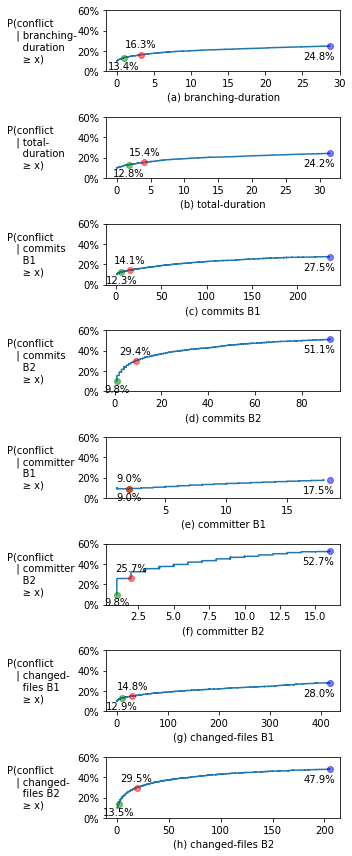

In [4]:
fig, axs = plt.subplots(len(attributes))
for i, (attr, ax) in enumerate(zip(attributes, axs)):
    nattr = attributes[attr]
    yattr = '\n     '.join(nattr.split('<>'))
    xattr = ''.join(nattr.split('<>'))
    letter = string.ascii_lowercase[i]
    

    min_whisker = min(results[attr]['wo_min_whisker'], results[attr]['wc_min_whisker'])
    max_whisker = max(results[attr]['wo_max_whisker'], results[attr]['wc_max_whisker'])  
    data = results[attr]['data']
    data = data[(data['x'] >= min_whisker) & (data['x'] <= max_whisker)]

    ax.plot(data['x'], data['y'])
    ax.set_xlabel(f"({letter}) {xattr}")
    ax.set_ylabel(f"P(conflict \n   | {yattr}\n     ≥ x)",  rotation=0, labelpad=70, ha='left', va='center')
    ax.set_ylim(0,0.6)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    x, y = results[attr]['wo_median'], data[data['x'] >= results[attr]['wo_median']]['y'].iloc[-1]
    ax.annotate(f'{y:.1%}', (x, y - 0.08), ha='center', va='center')
    ax.plot(x, y, 'go', alpha=0.5)
    
    x, y = results[attr]['wc_median'], data[data['x'] >= results[attr]['wc_median']]['y'].iloc[-1]
    ax.annotate(f'{y:.1%}', (x, y + 0.1), ha='center', va='center')
    ax.plot(x, y, 'ro', alpha=0.5)
    
    x, y = max_whisker, data['y'].iloc[0]
    ax.annotate(f'{y:.1%}', (x - 0.05*max_whisker, y - 0.1), ha='center', va='center')
    ax.plot(x, y, 'bo', alpha=0.5)
    
fig.set_size_inches([5, 12])
plt.tight_layout()
fig.savefig(f"output/bayes/0_all.png")
fig.savefig(f"output/bayes/0_all.svg")
fig.savefig(f"output/bayes/0_all.pdf")


In [5]:
results["Committers B1"]['median']

2.0

In [6]:
results["Changed Files B2"]['wo_median']

2.0

In [7]:
results["Changed Files B2"]['wc_median']

19.0

In [8]:
results["Changed Files B2"]['wc_max_whisker']

205.0

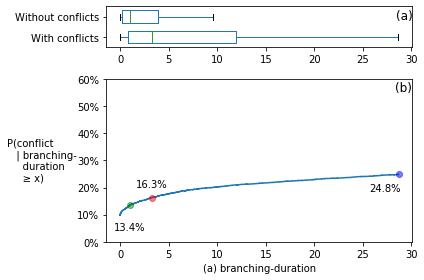

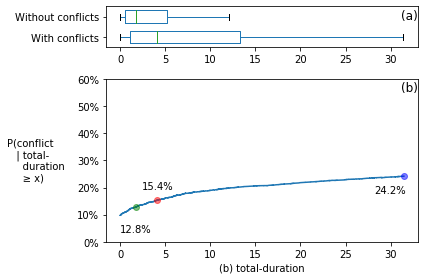

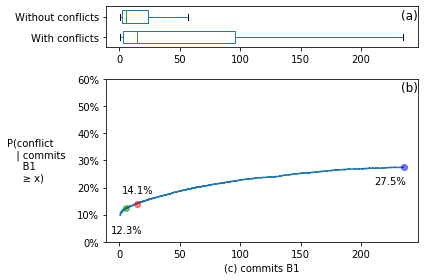

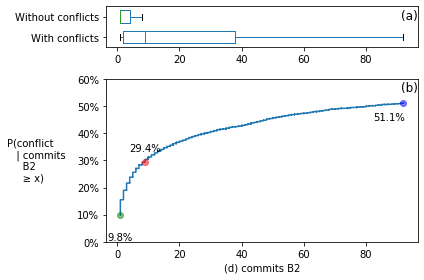

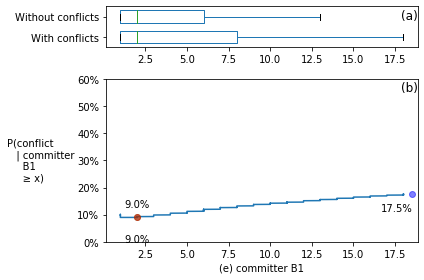

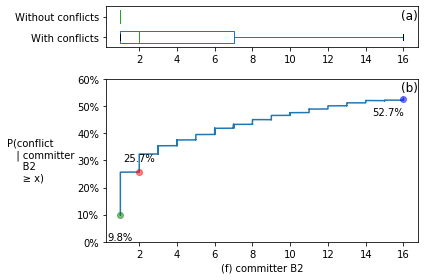

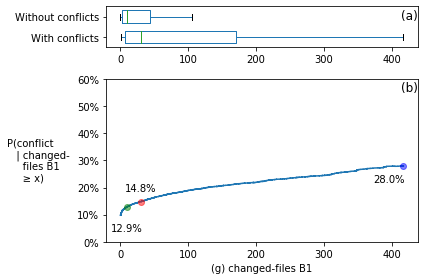

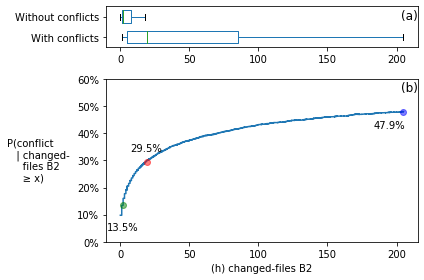

In [9]:
for i, attr in enumerate(attributes):
    nattr = attributes[attr]
    yattr = '\n     '.join(nattr.split('<>'))
    xattr = ''.join(nattr.split('<>'))
    letter = string.ascii_lowercase[i]
    
    fig, (ax2, ax) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    p = df.boxplot(ax=ax2, grid=False, vert=False, widths = 0.6, showfliers=False, column=attr, by="Conflicts")
    fig.suptitle('')
    ax2.set_title("")
    xlim = ax2.get_xlim()
    ax2.set_xlabel(f"")
    ax2.set_title("(a)", loc="right", y=0.55)

    min_whisker = min(results[attr]['wo_min_whisker'], results[attr]['wc_min_whisker'])
    max_whisker = max(results[attr]['wo_max_whisker'], results[attr]['wc_max_whisker'])  
    data = results[attr]['data']
    data = data[(data['x'] >= min_whisker) & (data['x'] <= max_whisker)]

    ax.plot(data['x'], data['y'])
    ax.set_xlabel(f"({letter}) {xattr}")
    ax.set_ylabel(f"P(conflict \n   | {yattr}\n     ≥ x)",  rotation=0, labelpad=70, ha='left', va='center')
    ax.set_ylim(0,0.6)
    ax.set_xlim(xlim)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.set_title("(b)", loc="right", y=0.89)
    
    x, y = results[attr]['wo_median'], data[data['x'] >= results[attr]['wo_median']]['y'].iloc[-1]
    ax.annotate(f'{y:.1%}', (x, y - 0.08), ha='center', va='center')
    ax.plot(x, y, 'go', alpha=0.5)
    
    x, y = results[attr]['wc_median'], data[data['x'] >= results[attr]['wc_median']]['y'].iloc[-1]
    ax.annotate(f'{y:.1%}', (x, y + 0.05), ha='center', va='center')
    ax.plot(x, y, 'ro', alpha=0.5)
    
    x, y = max_whisker, data['y'].iloc[0]
    ax.annotate(f'{y:.1%}', (x - 0.05*max_whisker, y - 0.05), ha='center', va='center')
    ax.plot(x, y, 'bo', alpha=0.5)
    ax2.xaxis.set_tick_params(which='both', labelbottom=True)


    plt.tight_layout()

    display(fig)
    fig.savefig(f"output/bayes/{letter}_{xattr}.png")
    fig.savefig(f"output/bayes/{letter}_{xattr}.svg")
    fig.savefig(f"output/bayes/{letter}_{xattr}.pdf")
    plt.close()

In [10]:
results.keys()

dict_keys(['Branching-duration', 'Total-duration', 'Commits B1', 'Commits B2', 'Committers B1', 'Committers B2', 'Changed Files B1', 'Changed Files B2'])

In [11]:
def first_gt(value, x, y, index=0, sortkey=0):
    
    items = sorted(map(list, zip(x, y)), key=lambda v: v[sortkey])
    
    for vi in items:
        if vi[index] >= value:
            return vi[(index + 1) % 2]

In [12]:
attr = 'Branching-duration'
data = results[attr]['data']
fd = data
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Branching-duration >= 0.0) = 10%


In [13]:
attr = 'Branching-duration'
data = results[attr]['data']
fd = data[data['x'] >= 10]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Branching-duration >= 10.0) = 20%


In [14]:
attr = 'Commits B1'
data = results[attr]['data']
fd = data[data['x'] >= 0]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")


P(conflicts | Commits B1 >= 1.0) = 10%


In [15]:
attr = 'Commits B2'
data = results[attr]['data']
fd = data[data['x'] >= 0]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Commits B2 >= 1.0) = 10%


In [16]:
attr = 'Commits B1'
data = results[attr]['data']
fd = data[data['x'] >= 30]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Commits B1 >= 30.0) = 16%


In [17]:
attr = 'Commits B2'
data = results[attr]['data']
fd = data[data['x'] >= 30]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Commits B2 >= 30.0) = 40%


In [18]:
attr = 'Committers B1'
data = results[attr]['data']
fd = data[data['x'] >= 0]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Committers B1 >= 1.0) = 10%


In [19]:
attr = 'Committers B1'
data = results[attr]['data']
fd = data[data['x'] >= 6]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Committers B1 >= 6.0) = 11%


In [20]:
attr = 'Committers B2'
data = results[attr]['data']
fd = data[data['x'] >= 6]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Committers B2 >= 6.0) = 40%


In [21]:
attr = 'Changed Files B1'
data = results[attr]['data']
fd = data[data['x'] >= 40]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Changed Files B1 >= 40.0) = 16%


In [22]:
attr = 'Changed Files B2'
data = results[attr]['data']
fd = data[data['x'] >= 40]
x, y = fd['x'].iloc[-1], fd['y'].iloc[-1]
print(f"P(conflicts | {attr} >= {x}) = {y:.0%}")

P(conflicts | Changed Files B2 >= 40.0) = 36%


Figures stored in `output/bayes`